## Reduced variance emulators on the Australia20 sim suite

Here we experiment with different emulator setups on the Aus20 suite. For now we are using the simulation closest to the centre of the initial LH as our fiducial sim. First we test emulating $(1+k)P_{1D}(k)$, then $P_{1D}(k)/(1+z)^{3.8}$. Then we also compare adding $\tau$ rescalings to the mix.

NB I have found $\tau$ rescalings can only be added in a way that improves emulator predictions when the hyperparameters are optimised on the dataset without $\tau$ rescalings. I think this might be due to the fact that having more parameter samples in one direction (in the $\tau$ direction) might mess with the hyperparamter optimisation in some way. But we do see some improvement when the $\tau$ rescalings are added to a training set where the hyperparameters have already been optimised.


In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
test_sim_num=16
skewers_label='Ns500_wM0.05'
#skewers_label=None
#basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
basedir="/p1d_emulator/sim_suites/Australia20/"
p1d_label=None
undersample_z=12
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]

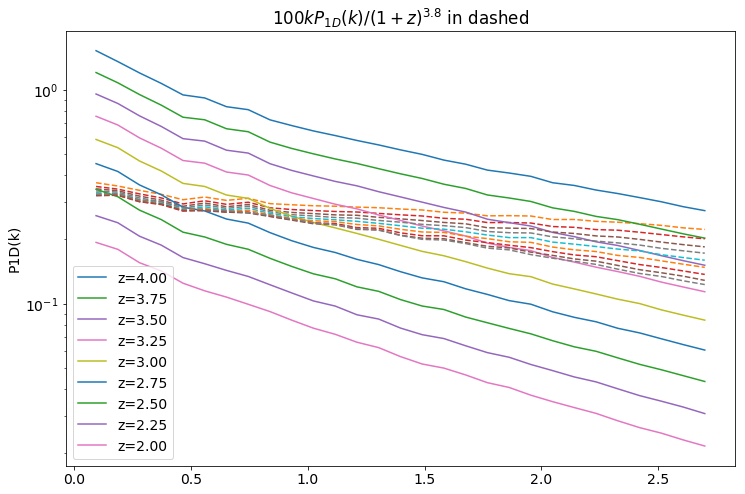

In [5]:
## What we were emulating before: P1D(k)
plt.figure(figsize=(12,8))
plt.title(r"$100kP_{1D}(k)/(1+z)^{3.8}$ in dashed")
for item in truth.data:
    plt.plot(item["k_Mpc"][1:30],item["p1d_Mpc"][1:30],label="z=%.2f" % item["z"])
    #plt.plot(item["k_Mpc"][1:30],100*(((1+item["z"])**-3.8)*item["k_Mpc"][1:30]*item["p1d_Mpc"][1:30]),linestyle="dashed")
    plt.plot(item["k_Mpc"][1:30],100*(((1+item["z"])**-3.8)*((1+item["k_Mpc"][1:30]))*item["p1d_Mpc"][1:30]),linestyle="dashed")
plt.yscale("log")
plt.legend()
plt.ylabel("P1D(k)")
plt.show()

In [6]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


In [7]:
arxiv_tau=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=False,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [8]:
## Standard emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


In [9]:
emu_red_k=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                reduce_var_k=True)

Training GP on 261 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [10]:
emu_red_z=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                reduce_var_z=True)

Training GP on 261 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [11]:
emu_red_both=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                reduce_var_k=True,
                                reduce_var_z=True)

Training GP on 261 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [22]:
emu_tau=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=False,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv_tau)
emu_tau.load_hyperparams(emu.gp.param_array,emu.paramLimits)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Text(0.5, 132.40000000000015, 'k 1/Mpc')

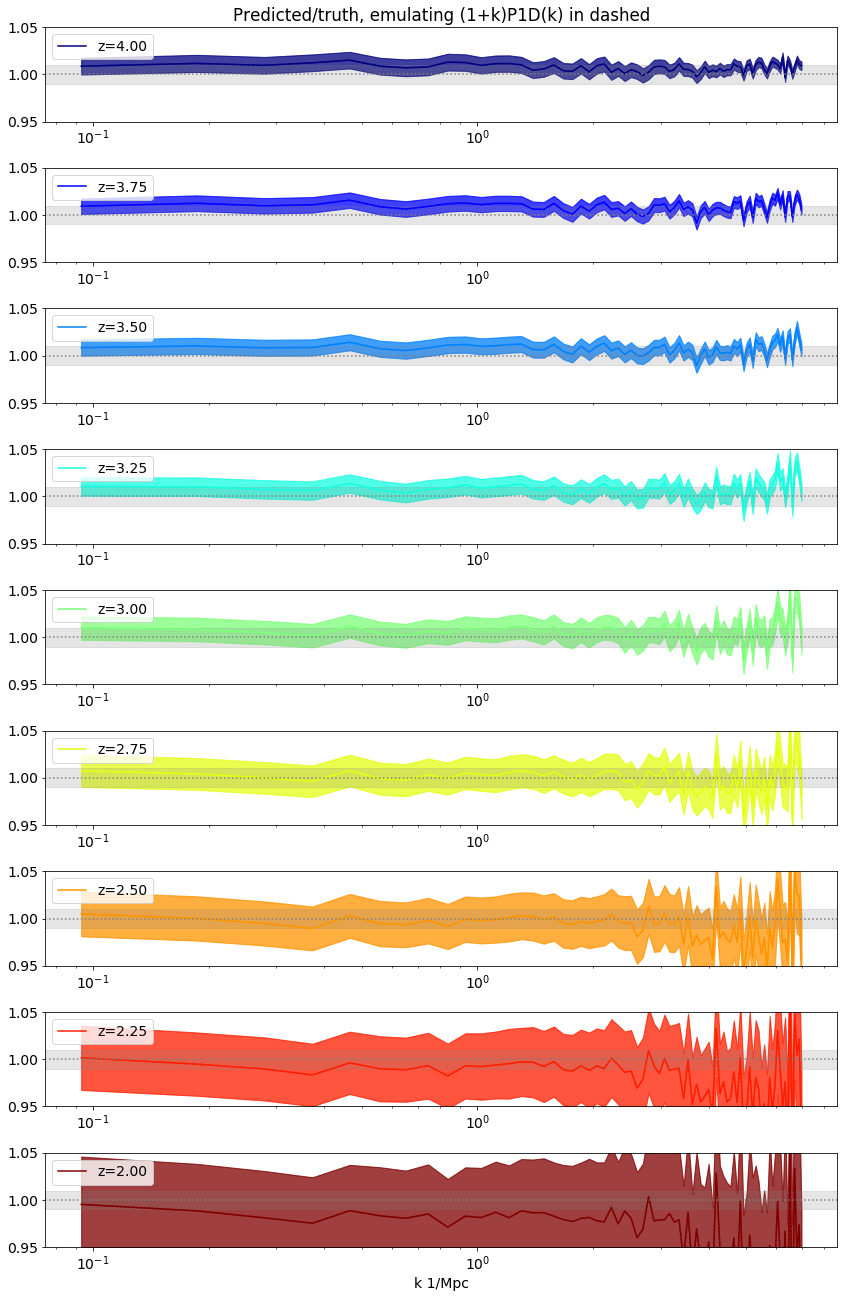

In [13]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating (1+k)P1D(k) in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu_red_k.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")

Text(0.5, 132.40000000000015, 'k 1/Mpc')

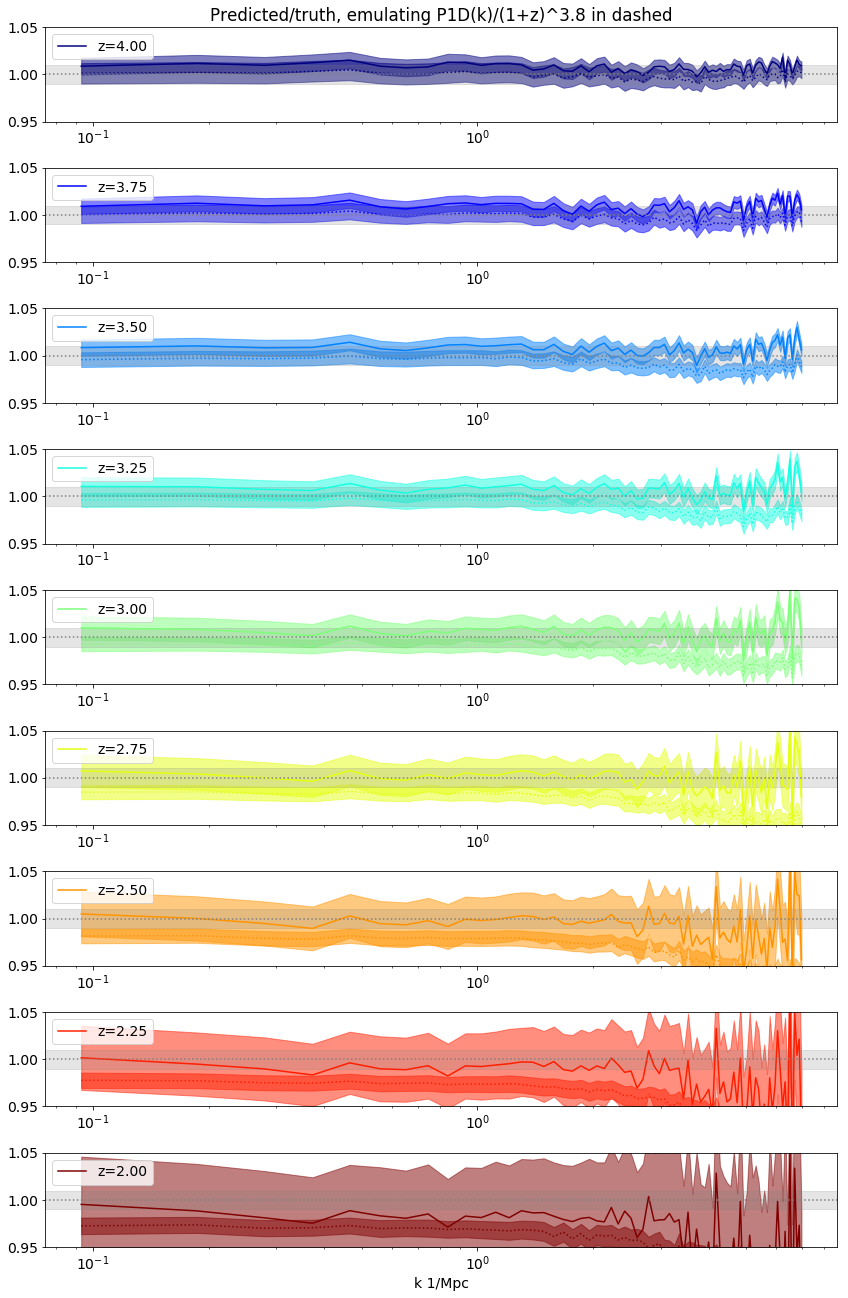

In [24]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating P1D(k)/(1+z)^3.8 in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu_red_z.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    #print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")

Text(0.5, 132.40000000000015, 'k 1/Mpc')

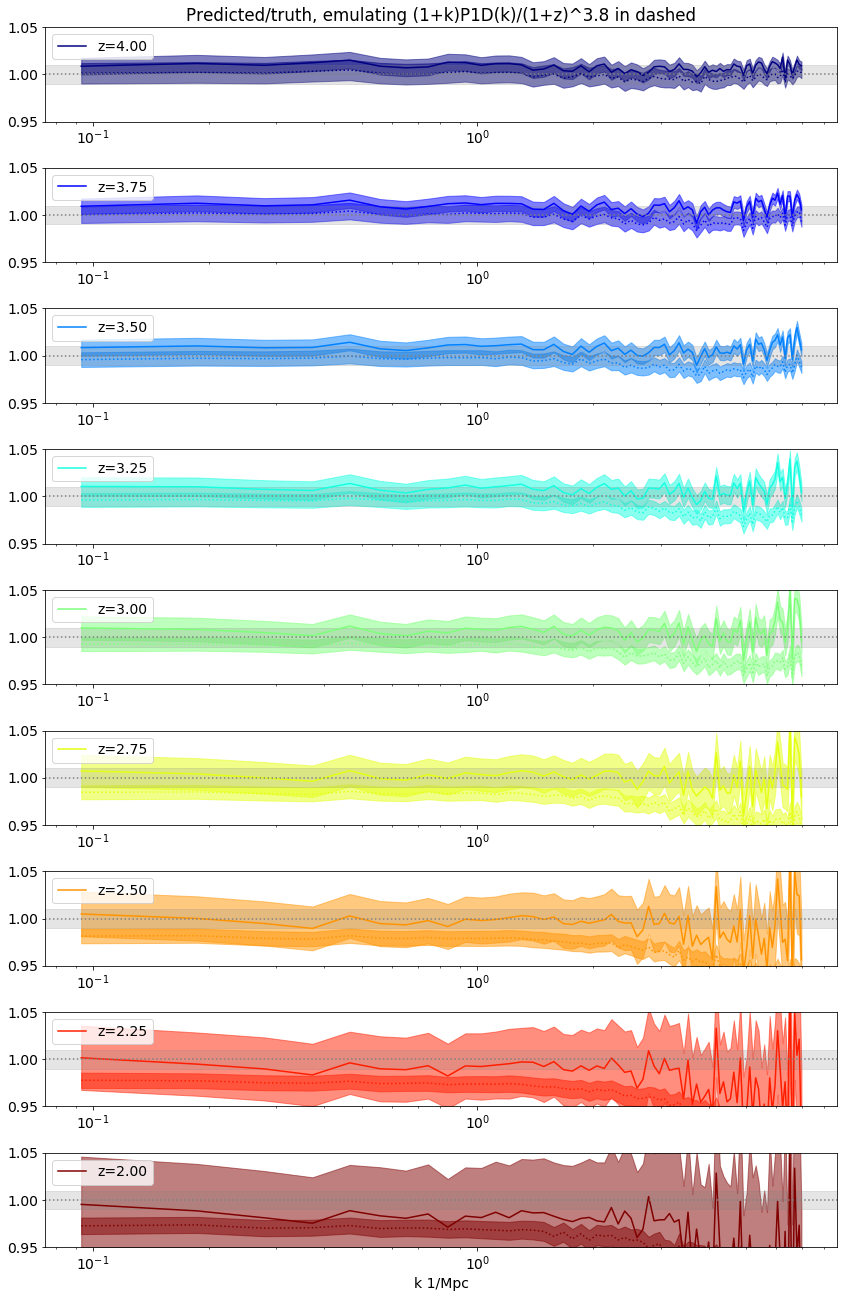

In [17]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, emulating (1+k)P1D(k)/(1+z)^3.8 in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu_red_both.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    #print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")

Text(0.5, 132.40000000000015, 'k 1/Mpc')

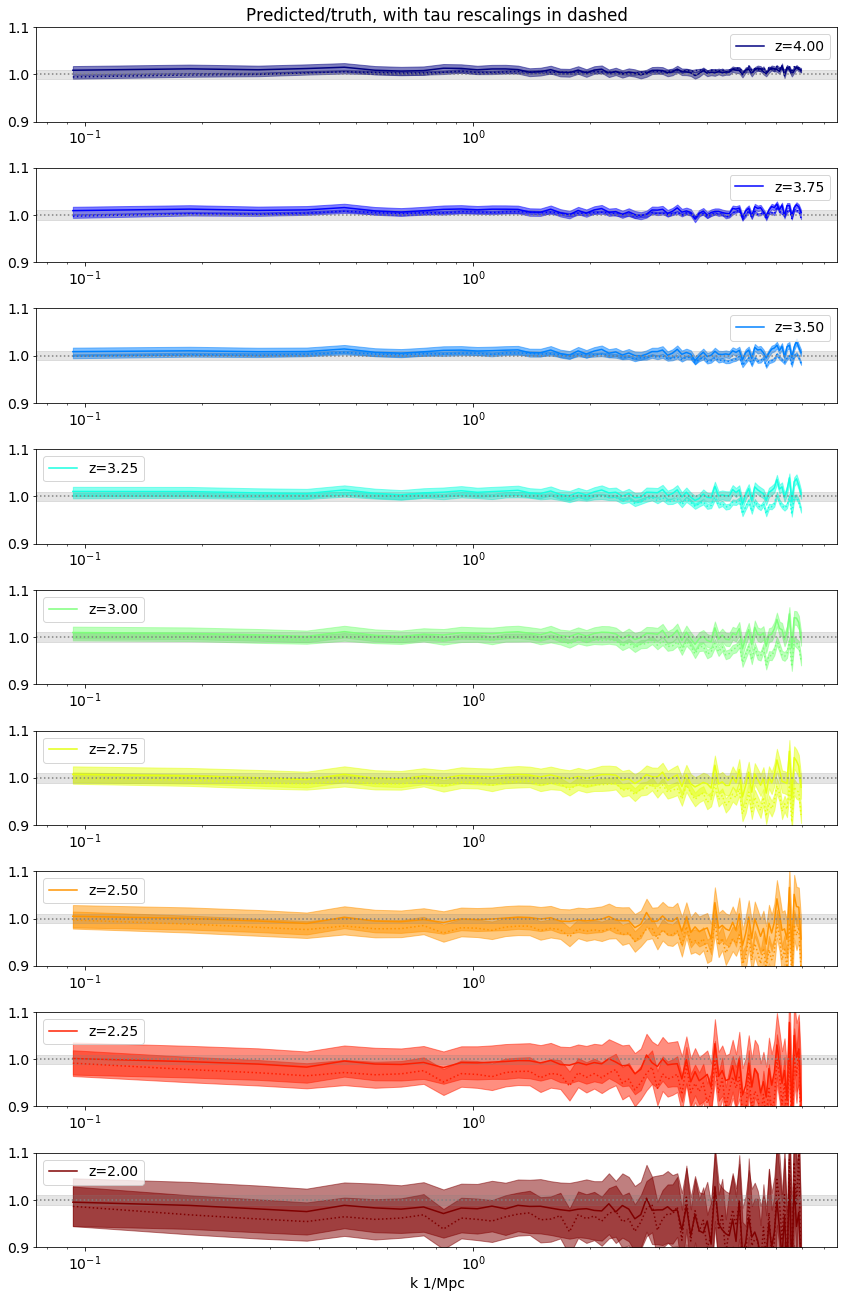

In [27]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, with tau rescalings in dashed")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu_tau.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    #print(pred-pred_tau)
    ## Plot z with different limits
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test))+1],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test))+1],alpha=0.5,color=col)
    
    plt.axhline(1,linestyle=":",color="gray")
    plt.xscale("log")
    plt.ylim(0.9,1.1)
    plt.legend()

plt.tight_layout()
plt.xlabel("k 1/Mpc")